In [1]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_gme = pd.read_csv('data/GME.csv')
df_gme

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-01-03,2.868750,2.868750,2.657500,2.691250,1.812019,4844800
1,2005-01-04,2.691250,2.701250,2.566250,2.662500,1.792661,4378400
2,2005-01-05,2.637500,2.681250,2.628750,2.660000,1.790979,3254400
3,2005-01-06,2.660000,2.668750,2.643750,2.643750,1.780037,4820800
4,2005-01-07,2.487500,2.487500,2.343750,2.443750,1.645377,29349600
...,...,...,...,...,...,...,...
4535,2023-01-09,16.650000,17.129999,16.360001,16.379999,16.379999,3522600
4536,2023-01-10,16.299999,18.090000,16.250000,17.770000,17.770000,4402800
4537,2023-01-11,18.190001,20.049999,17.860001,19.040001,19.040001,8405800
4538,2023-01-12,19.040001,20.629999,18.340000,20.629999,20.629999,5877300


# New section

# New section

In [3]:
df_gme = df_gme[['Date', 'Close']]

In [4]:
df_gme['Date'].min(), df_gme['Date'].max()

('2005-01-03', '2023-01-13')

In [5]:
plt_ = go.Figure()
plt_.add_trace(go.Scatter(x=df_gme['Date'], y=df_gme['Close'], name='stocks close price'))
plt_.update_layout(showlegend=True, title='GME 2005-2023')
plt_.show()

In [6]:
train_data, test_data = df_gme.loc[df_gme.Date <= '2018-01-03'], df_gme.loc[(df_gme.Date  > '2018-01-03') & (df_gme.Date < '2021-04-03')]
train_data.shape, test_data.shape

((3274, 2), (816, 2))

In [7]:
train_data[-10:-1]

,Date,Close
3264,2017-12-19,4.5975
3265,2017-12-20,4.5625
3266,2017-12-21,4.6125
3267,2017-12-22,4.5725
3268,2017-12-26,4.6275
3269,2017-12-27,4.5625
3270,2017-12-28,4.5425
3271,2017-12-29,4.4875
3272,2018-01-02,4.5650


In [8]:
scale = StandardScaler()
scale = scale.fit(train_data[['Close']])

In [9]:
train_data['Close'] = scale.transform(train_data[['Close']])
test_data['Close'] = scale.transform(test_data[['Close']])

<ipython-input-9-cb8741b64bfa>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-9-cb8741b64bfa>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
# X = input, ts= time steps
def sequence_data(X,ts):
    X_seq, y_seq = [], []
    for i in range(len(X)-ts):
        X_seq.append(X.iloc[i:(i+ts)].values)
        y_seq.append(X.iloc[i+ts])
    return np.array(X_seq), np.array(y_seq)

In [11]:
X_train, y_train = sequence_data(train_data[['Close']], 60)
X_test, y_test = sequence_data(test_data[['Close']], 60)
X_train.shape

(3214, 60, 1)

In [12]:
def createModel(x, y):
    model = Sequential()
    model.add(LSTM(128, input_shape=(x,y)))
    model.add(Dropout(rate=0.5))
    model.add(RepeatVector(X_train.shape[1]))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(rate=0.5))
    model.add(TimeDistributed(Dense(y)))
    model.compile(optimizer='adam', loss='mae')
    return model

In [13]:
model = createModel(X_train.shape[1],1)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 60, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 60, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 60, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 60, 1)            129       
 ibuted)                                                

In [14]:
his = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/10
81/81 [==============================] - 43s 390ms/step - loss: 0.2547 - val_loss: 0.0943
Epoch 2/10
81/81 [==============================] - 20s 242ms/step - loss: 0.1630 - val_loss: 0.0746
Epoch 3/10
81/81 [==============================] - 18s 225ms/step - loss: 0.1772 - val_loss: 0.1070
Epoch 4/10
81/81 [==============================] - 20s 242ms/step - loss: 0.1669 - val_loss: 0.1299
Epoch 5/10
81/81 [==============================] - 18s 226ms/step - loss: 0.1755 - val_loss: 0.1210


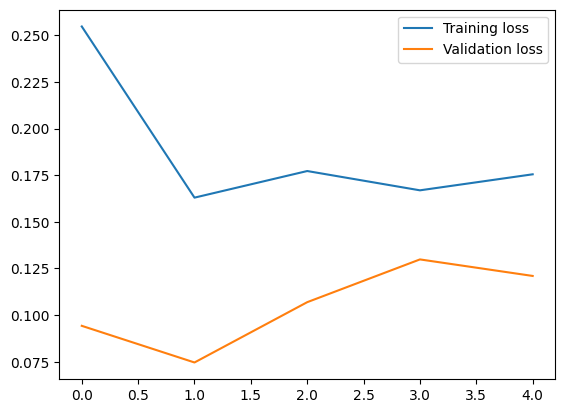

In [15]:
plt.plot(his.history['loss'], label='Training loss')
plt.plot(his.history['val_loss'], label='Validation loss')
plt.legend();

In [16]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 2s 72ms/step - loss: 0.7860


0.785983145236969

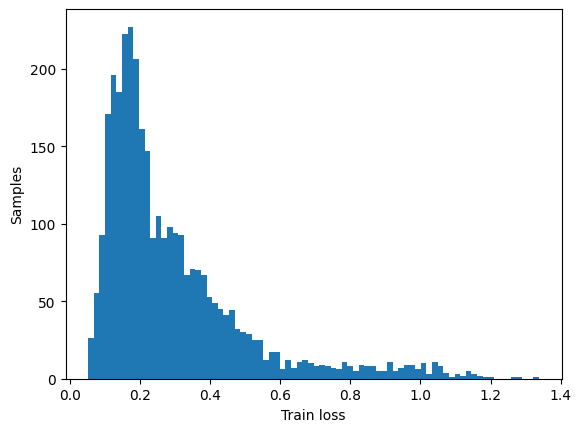

In [17]:
X_train_pred = model.predict(X_train, verbose=0)
train_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
plt.hist(train_loss, bins=80)
plt.xlabel('Train loss')
plt.ylabel('Samples');
threshold = np.max(train_loss+0.5)

Text(0.5, 0, 'Test loss')

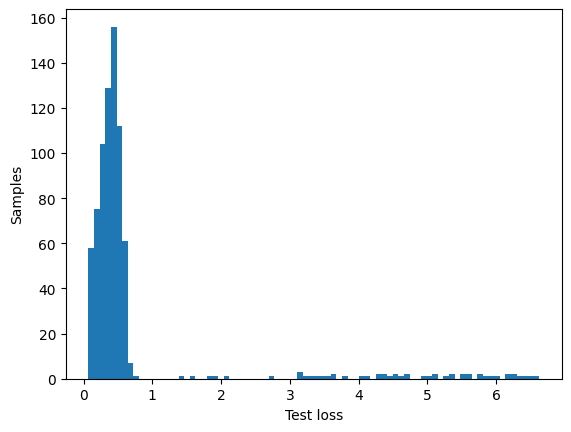

In [18]:
X_test_pred = model.predict(X_test, verbose=0)
test_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)
plt.hist(test_loss, bins=80)
plt.ylabel('Samples')
plt.xlabel('Test loss')

In [19]:
result_df = pd.DataFrame(test_data[60:])
result_df['Anomaly'] = test_loss > threshold
result_df.Close = test_data[60:].Close
anomalies_df = result_df.loc[result_df.Anomaly]

In [20]:
def getAccuracy(anomaly_start_date, anomaly_end_date, result_df):
    result_df['True Anomaly'] = False  # Initialize the 'true anomaly' column

    # Set 'True Anomaly' values for the desired date range
    result_df.loc[(result_df['Date'] >= anomaly_start_date) & (result_df['Date'] <= anomaly_end_date), 'True Anomaly'] = True
    # Assuming 'result_df' has been created as mentioned earlier
    true_anomalies = result_df[result_df['True Anomaly']]
    predicted_anomalies = result_df[result_df['Anomaly']]

    # Calculate the number of correctly predicted anomalies
    correctly_predicted = len(predicted_anomalies[predicted_anomalies['True Anomaly']])

    # Calculate the total number of actual anomalies
    total_actual_anomalies = max(1, len(true_anomalies))

    # Calculate the accuracy
    accuracy = min(1,correctly_predicted / total_actual_anomalies)

    return accuracy


In [21]:
anomaly_start_date = '2021-01-15'
anomaly_end_date = '2021-04-01'
print("Accuracy:", getAccuracy(anomaly_start_date, anomaly_end_date, result_df))

Accuracy: 0.9433962264150944


In [22]:
plt_ = go.Figure()
plt_.update_layout(showlegend=True, title='Anomalies')
plt_.add_trace(go.Scatter(x=result_df.Date, y=result_df.Close, name='Stock Price'))
plt_.add_trace(go.Scatter(x=anomalies_df.Date, y=anomalies_df.Close, mode='markers', name='Anomaly Detected'))
plt_.update_yaxes(visible=False)
plt_.show()